# **⬇️ Import Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import models,layers

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import models,layers

from keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
# Path to the folder containing the numbered images
image_folder = '/content/drive/MyDrive/Leaf images'

# Path to the CSV file
csv_file_path = '/content/drive/MyDrive/train.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Function to load and parse images
def load_images_and_labels(image_folder, df, max_size=(1620, 1050), target_size=(244,244)):
    data = []
    labels = []

    for index, row in df.iterrows():
        image_id = row['id']
        species = row['species']

        # Construct the image file path based on the ID
        image_path = os.path.join(image_folder, f"{image_id}.jpg")

        # Load the image using OpenCV in grayscale mode
        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


        # Resize the image to the max size with replicated padding
        height, width = image.shape
        new_height, new_width = max_size

        # Calculate padding
        pad_height = max(0, (new_height - height) // 2)
        pad_width = max(0, (new_width - width) // 2)

        # Replicate padding
        image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_REPLICATE)


        # Resize the image to the target size
        new_height, new_width = target_size

        image = cv2.resize(image, (new_width, new_height))

        # Convert OpenCV image to TensorFlow tensor
        numpy_array = np.array(image)

         # Append the image and label to the lists
        data.append(numpy_array)
        labels.append(species)

    return data,labels

# Load images and labels
images,labels = load_images_and_labels(image_folder, df, max_size=(1620, 1050), target_size=(244,244))



In [4]:
updated_labels = np.array(labels)
updated_images= np.array(images)

In [5]:
print(updated_images.shape)
print(updated_labels.shape)

(990, 244, 244)
(990,)


In [6]:
updated_images= updated_images.reshape(len(updated_images),244,244,1)
updated_labels= updated_labels.reshape(len(updated_labels),1)

In [7]:
print(updated_images.shape)
print(updated_labels.shape)

(990, 244, 244, 1)
(990, 1)


In [8]:
LabelEncoder  = preprocessing.LabelEncoder()
LabelEncoder.fit(updated_labels)
num_labels = LabelEncoder.transform(updated_labels)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### **Try different Optimizers**

In [19]:
from keras import regularizers

# List of regularizers and their corresponding regularization values to try
regularizers_values = [('l1', [0.001, 0.01, 0.1]), ('l2', [0.001, 0.01, 0.1]), ('l1_l2', [0.001, 0.01, 0.1])]

# Dictionary to store accuracy results for each regularizer
accuracy_results = {}

# Iterate through each regularizer and its regularization values
for regularizer, regularization_values in regularizers_values:
    for regularization_value in regularization_values:
        network = models.Sequential()


        # First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
        # with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
        network.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(244, 244, 1)))
        network.add(layers.MaxPool2D((2,2)))  # Reduced the pool size to (2,2) to reduce aggressive downsampling
        network.add(layers.Dropout(0.15))

        # Second convolutional layer with 64 filters
        network.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        network.add(layers.MaxPool2D((2,2)))
        network.add(layers.Dropout(0.15))

        # Third convolutional layer with 128 filters
        network.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        network.add(layers.MaxPool2D((2,2)))
        network.add(layers.Dropout(0.15))

        # Fourth convolutional layer with 256 filters
        network.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
        network.add(layers.MaxPool2D((2,2)))
        network.add(layers.Dropout(0.15))

        # Flatten layer
        network.add(layers.Flatten())

        # Dense layer of 512 neurons with ReLU activation function and regularizer
        if regularizer == 'l1':
            reg = regularizers.l1(regularization_value)
        elif regularizer == 'l2':
            reg = regularizers.l2(regularization_value)
        elif regularizer == 'l1_l2':
            reg = regularizers.l1_l2(l1=regularization_value, l2=regularization_value)
        network.add(layers.Dense(512, activation='relu', kernel_regularizer=reg))
        network.add(layers.Dropout(0.15))

        # Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the
        # activation function
        network.add(layers.Dense(99, activation='softmax'))

        # Compile the model with Adam optimizer
        network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        X_train, X_test, Y_train, Y_test = train_test_split(updated_images, num_labels, test_size=0.2, random_state=5, shuffle=True)

        Y_train_one_hot = to_categorical(Y_train, num_classes = 99)

        # Print network summary to check the layer shapes
        print(network.summary())
        # Train the model
        history = network.fit(X_train, Y_train_one_hot, epochs=50, batch_size=32, verbose=1)

        # Store the accuracy results for the current regularizer and regularization value
        accuracy_results[(regularizer, regularization_value)] = history.history['accuracy']




Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 122, 122, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_105 (Dropout)       (None, 122, 122, 32)      0         
                                                                 
 conv2d_85 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_106 (Dropout)       (None, 61, 61, 64)      

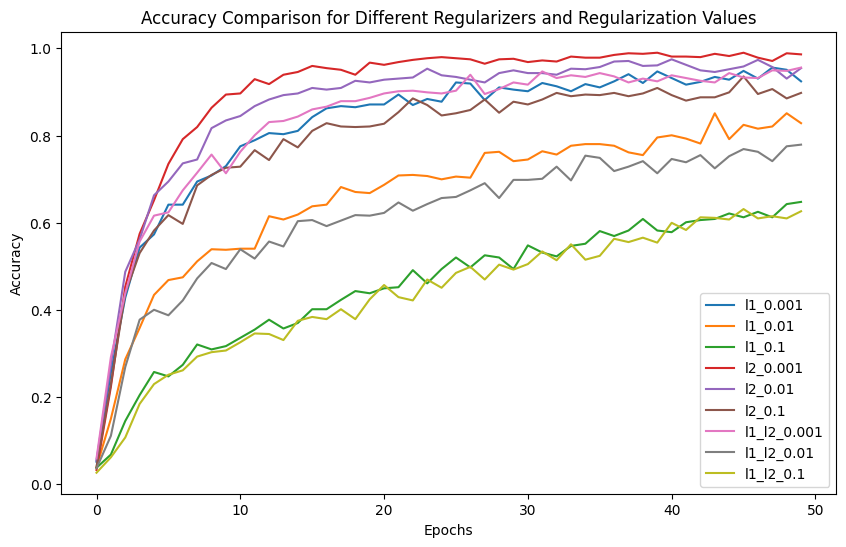

In [20]:
# Plot the accuracy results for each regularizer and regularization value
plt.figure(figsize=(10, 6))
for (regularizer, regularization_value), accuracy_values in accuracy_results.items():
    plt.plot(accuracy_values, label=f'{regularizer}_{regularization_value}')

plt.title('Accuracy Comparison for Different Regularizers and Regularization Values')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()